<a href="https://colab.research.google.com/github/safeai-snu/TimeSeriesAI/blob/main/ch1/ch1_2_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [2]:
train_df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/dataset/ch1/train.csv', index_col=0)
val_df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/dataset/ch1/val.csv', index_col=0)
test_df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/dataset/ch1/test.csv', index_col=0)

In [3]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

# Baseline models (Naive forecasting)

## Single-step baseline model

### 윈도우 설정

In [4]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume']) #시각화를 위해

### 모델

In [5]:
class Baseline(Model): #Naive forecasting
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

### 모델 피팅

In [6]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

### 성능 평가

In [7]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)


110/110 [==============================] - 0s 1ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


### 시각화

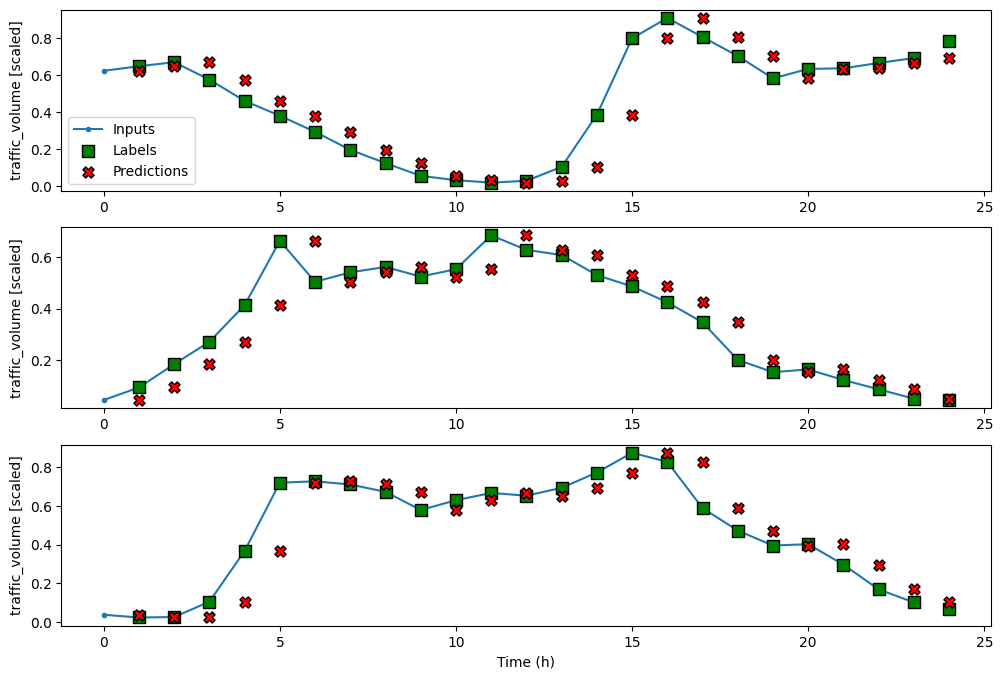

In [8]:
wide_window.plot(baseline_last)

In [9]:
print(performance['Baseline - Last'][1])

0.08128399401903152


## Multi-step baseline model

### 윈도우 설정

In [10]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

### 모델

In [11]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

### 모델 피팅

In [12]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

### 성능 평가

In [13]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 1ms/step - loss: 0.1875 - mean_absolute_error: 0.3522


### 시각화

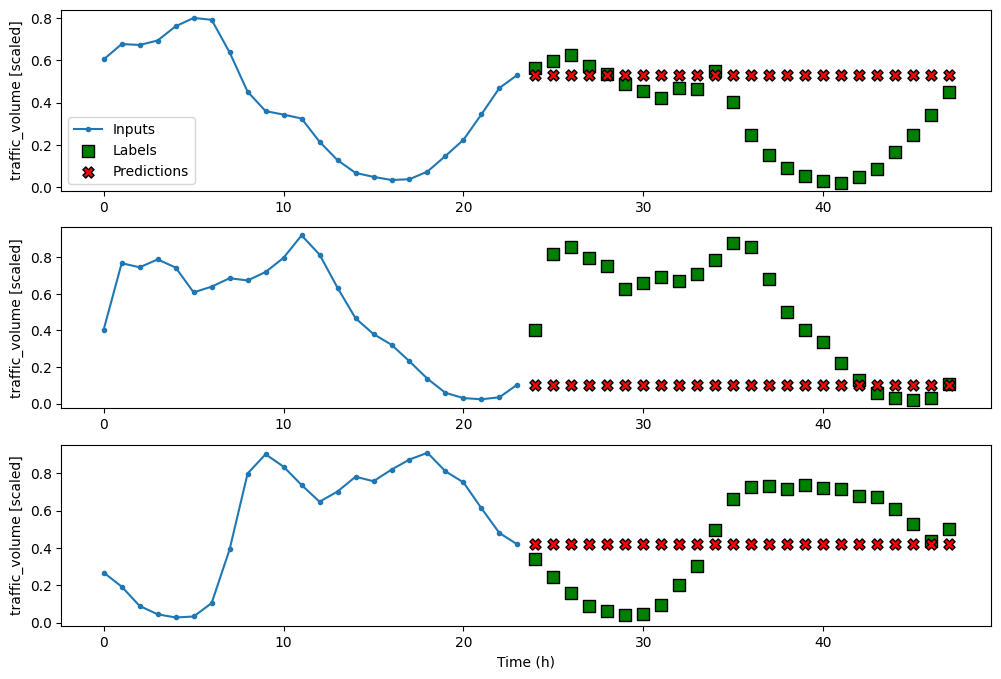

In [14]:
multi_window.plot(ms_baseline_last)

In [15]:
print(ms_performance['Baseline - Last'][1])

0.34726065397262573


## Multi-output baseline model

### 윈도우 설정

In [16]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

### 모델

In [17]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list): #다중 출력을 위함
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

### 모델 피팅

In [18]:
mo_baseline_last = Baseline(label_index=[column_indices['temp'], column_indices['traffic_volume']])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

### 성능 평가

In [19]:
mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0482


### 시각화

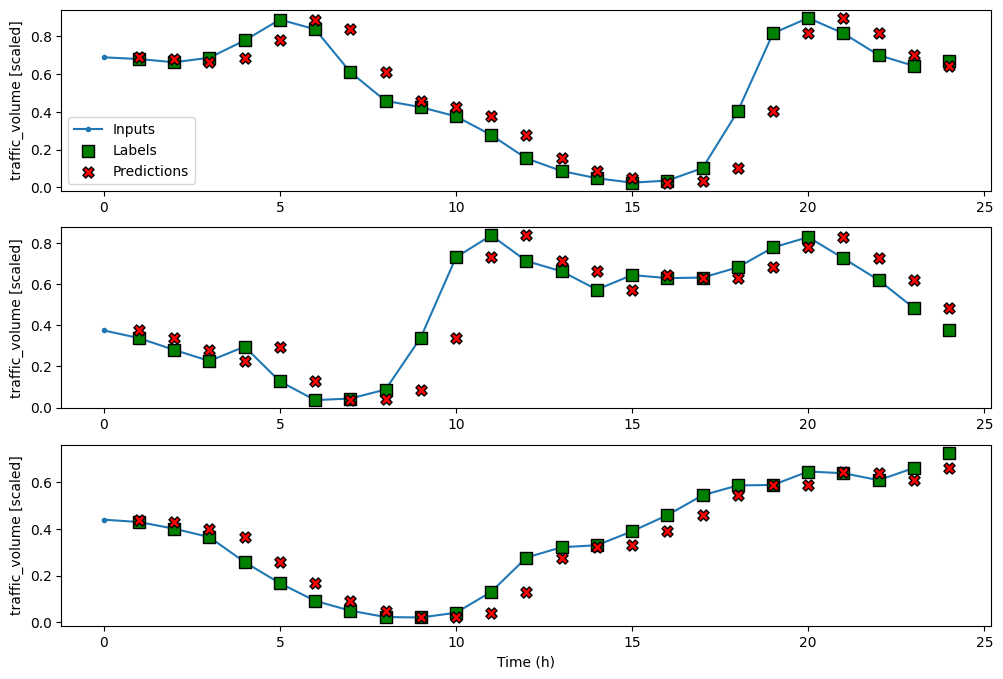

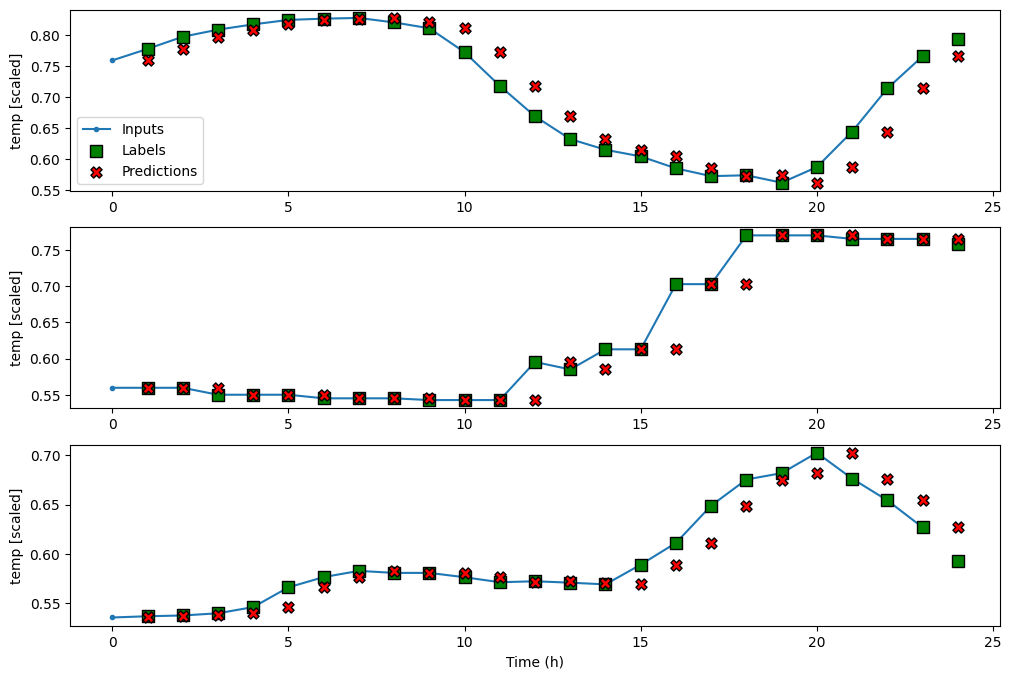

In [20]:
mo_wide_window.plot(mo_baseline_last)
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [21]:
print(mo_performance['Baseline - Last'][1])

0.04710666462779045


# Linear model

## Single-step linear model

### 모델 구성 및 데이터 피팅 함수

In [22]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

### 모델 피팅

In [23]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.6483 - mean_absolute_error: 0.6949 - val_loss: 0.2263 - val_mean_absolute_error: 0.3949
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.1304 - mean_absolute_error: 0.3020 - val_loss: 0.0999 - val_mean_absolute_error: 0.2645
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0730 - mean_absolute_error: 0.2228 - val_loss: 0.0599 - val_mean_absolute_error: 0.1943
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0434 - mean_absolute_error: 0.1633 - val_loss: 0.0367 - val_mean_absolute_error: 0.1456
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0271 - mean_absolute_error: 0.1243 - val_loss: 0.0245 - val_mean_absolute_error: 0.1179
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0191 - mean_absolute_error: 0.1029 - val_loss: 0.0186 - val_mean_absolute_error: 0.1027
Epoch 7/50
384/3

### 시각화

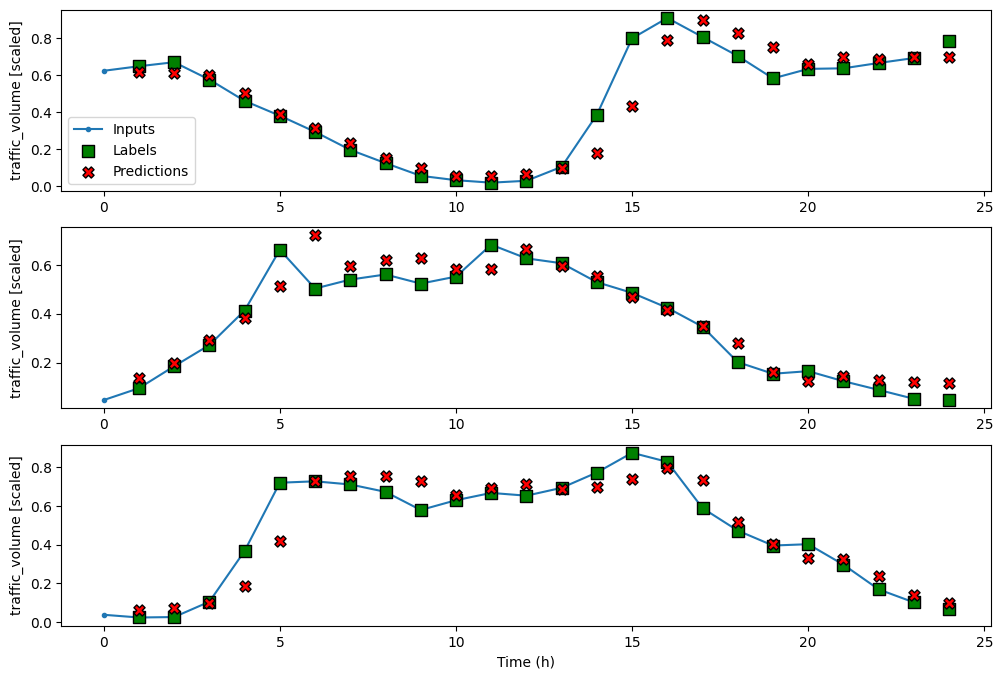

In [24]:
wide_window.plot(linear)

## Multi-step linear model

In [25]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0901 - mean_absolute_error: 0.2468 - val_loss: 0.0459 - val_mean_absolute_error: 0.1824
Epoch 2/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0299 - mean_absolute_error: 0.1370 - val_loss: 0.0262 - val_mean_absolute_error: 0.1256
Epoch 3/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0201 - mean_absolute_error: 0.1046 - val_loss: 0.0213 - val_mean_absolute_error: 0.1075
Epoch 4/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0177 - mean_absolute_error: 0.0955 - val_loss: 0.0196 - val_mean_absolute_error: 0.1003
Epoch 5/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0168 - mean_absolute_error: 0.0914 - val_loss: 0.0189 - val_mean_absolute_error: 0.0957
Epoch 6/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0164 - mean_absolute_error: 0.0887 - val_loss: 0.0185 - val_mean_absolute_error: 0.0926
Epoch 7/50
383/3

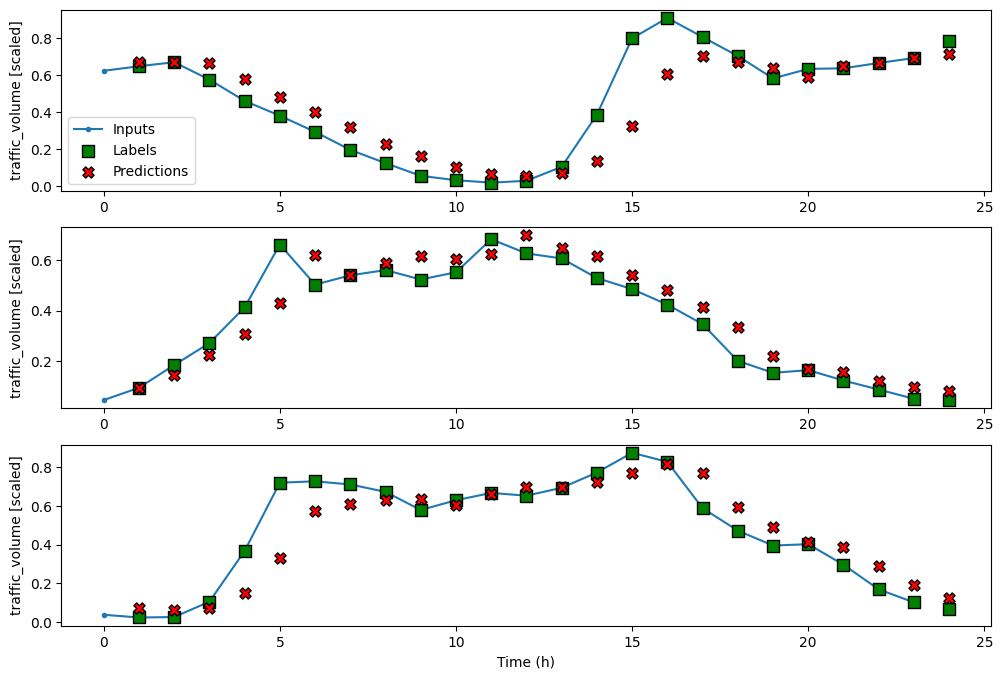

In [26]:
wide_window.plot(ms_linear)

## Multi-output linear model

In [27]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.3427 - mean_absolute_error: 0.4310 - val_loss: 0.1465 - val_mean_absolute_error: 0.2993
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.1124 - mean_absolute_error: 0.2571 - val_loss: 0.0904 - val_mean_absolute_error: 0.2307
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0655 - mean_absolute_error: 0.1947 - val_loss: 0.0547 - val_mean_absolute_error: 0.1772
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0396 - mean_absolute_error: 0.1482 - val_loss: 0.0349 - val_mean_absolute_error: 0.1385
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0261 - mean_absolute_error: 0.1158 - val_loss: 0.0245 - val_mean_absolute_error: 0.1110
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0191 - mean_absolute_error: 0.0941 - val_loss: 0.0186 - val_mean_absolute_error: 0.0919
Epoch 7/50
384/3

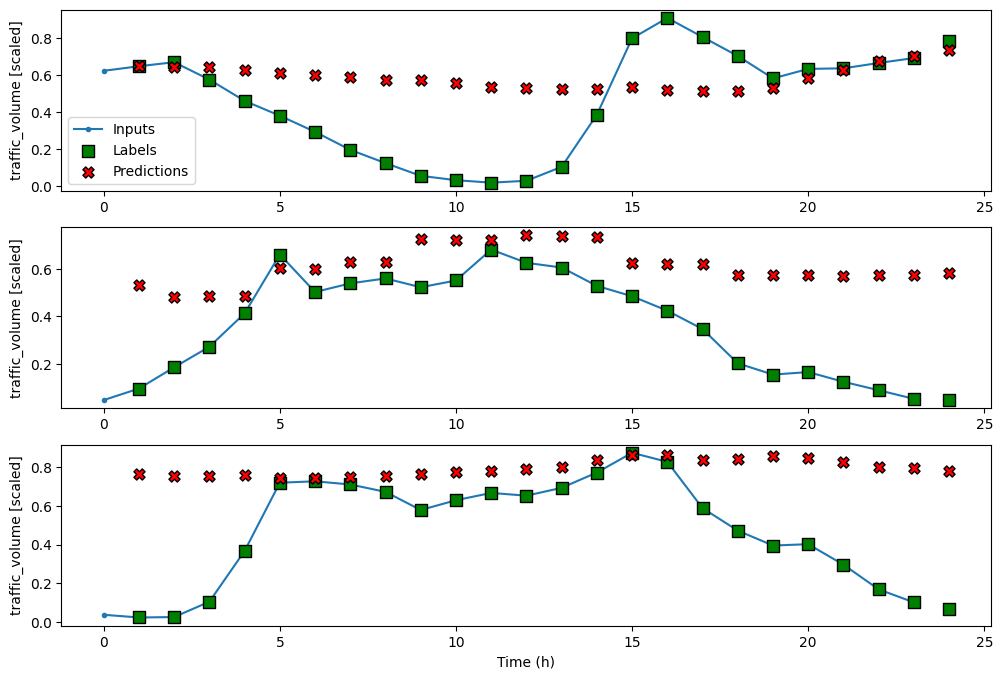

In [28]:
wide_window.plot(mo_linear)

# DNN

## Single-step DNN model

### 모델 피팅

In [29]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0739 - val_loss: 0.0045 - val_mean_absolute_error: 0.0516
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0040 - mean_absolute_error: 0.0465 - val_loss: 0.0031 - val_mean_absolute_error: 0.0413
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0034 - mean_absolute_error: 0.0427 - val_loss: 0.0028 - val_mean_absolute_error: 0.0396
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0414 - val_loss: 0.0030 - val_mean_absolute_error: 0.0409
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0403 - val_loss: 0.0026 - val_mean_absolute_error: 0.0376
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0389 - val_loss: 0.0026 - val_mean_absolute_error: 0.0376
Epoch 7/50
384/3

### 시각화

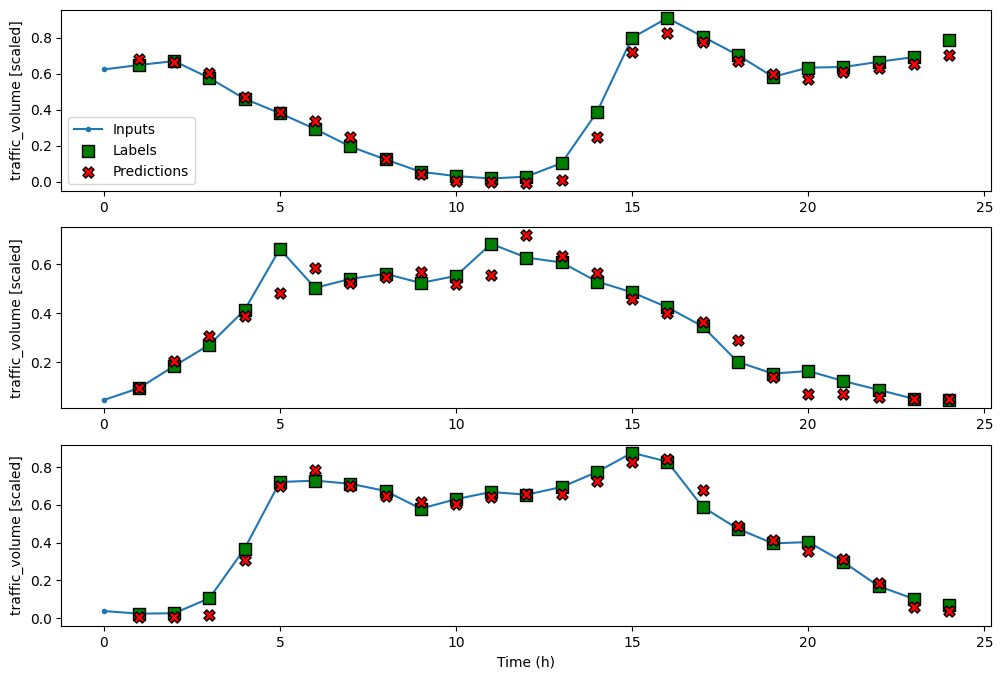

In [30]:
wide_window.plot(dense)

### 결과 비교

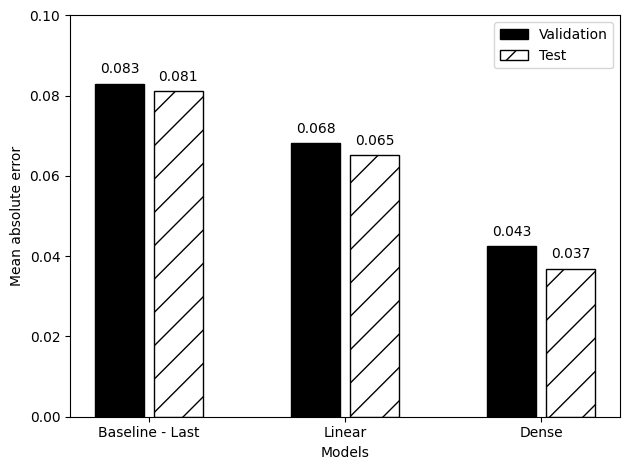

In [31]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## Multi-step DNN model

### 모델 피팅

In [32]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 2s 3ms/step - loss: 0.0290 - mean_absolute_error: 0.1073 - val_loss: 0.0163 - val_mean_absolute_error: 0.0851
Epoch 2/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0139 - mean_absolute_error: 0.0784 - val_loss: 0.0156 - val_mean_absolute_error: 0.0827
Epoch 3/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0136 - mean_absolute_error: 0.0778 - val_loss: 0.0153 - val_mean_absolute_error: 0.0808
Epoch 4/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0770 - val_loss: 0.0150 - val_mean_absolute_error: 0.0801
Epoch 5/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0130 - mean_absolute_error: 0.0762 - val_loss: 0.0150 - val_mean_absolute_error: 0.0790
Epoch 6/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0755 - val_loss: 0.0149 - val_mean_absolute_error: 0.0787
Epoch 7/50
383/3

### 시각화

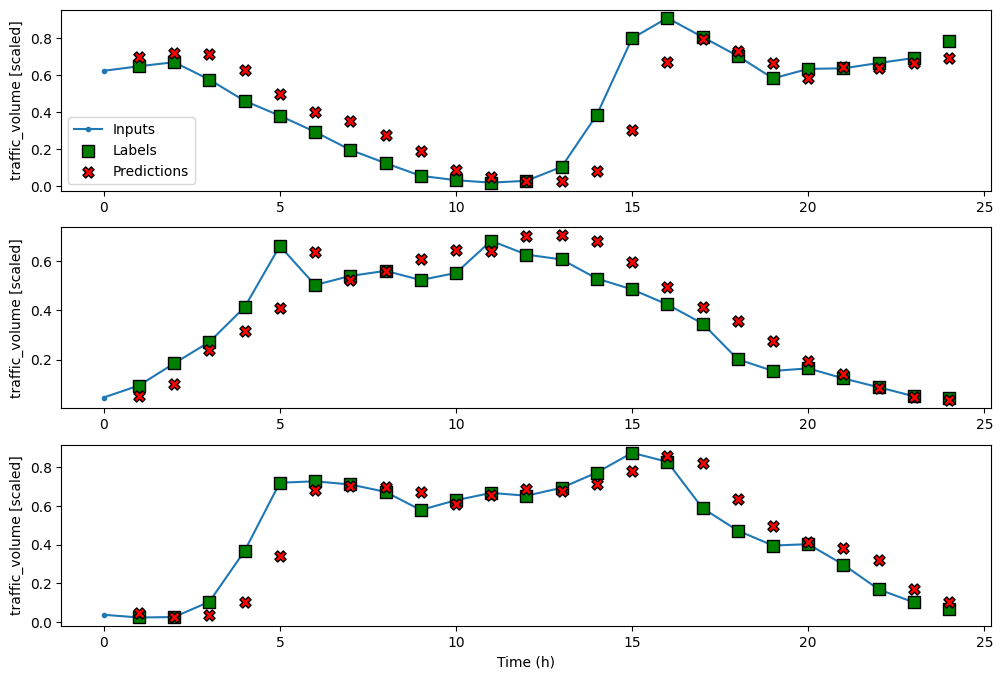

In [33]:
wide_window.plot(ms_dense)

### 결과 비교

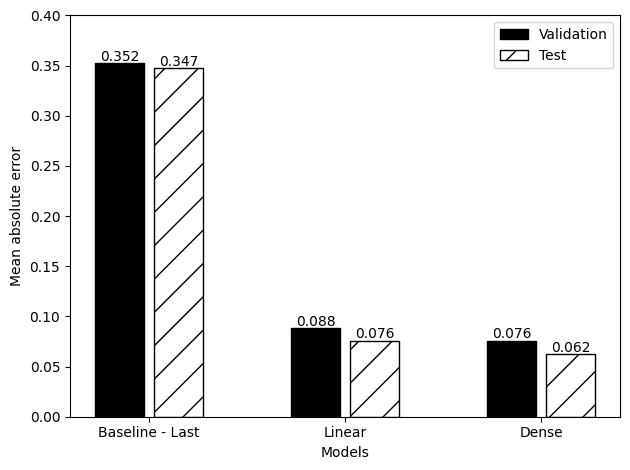

In [34]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## Multi-output DNN model

### 모델 피팅

In [35]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 2ms/step - loss: 0.0111 - mean_absolute_error: 0.0606 - val_loss: 0.0028 - val_mean_absolute_error: 0.0335
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_absolute_error: 0.0324 - val_loss: 0.0021 - val_mean_absolute_error: 0.0299
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0301 - val_loss: 0.0020 - val_mean_absolute_error: 0.0280
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0286 - val_loss: 0.0017 - val_mean_absolute_error: 0.0260
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0277 - val_loss: 0.0016 - val_mean_absolute_error: 0.0258
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0273 - val_loss: 0.0016 - val_mean_absolute_error: 0.0252
Epoch 7/50
384/3

### 시각화

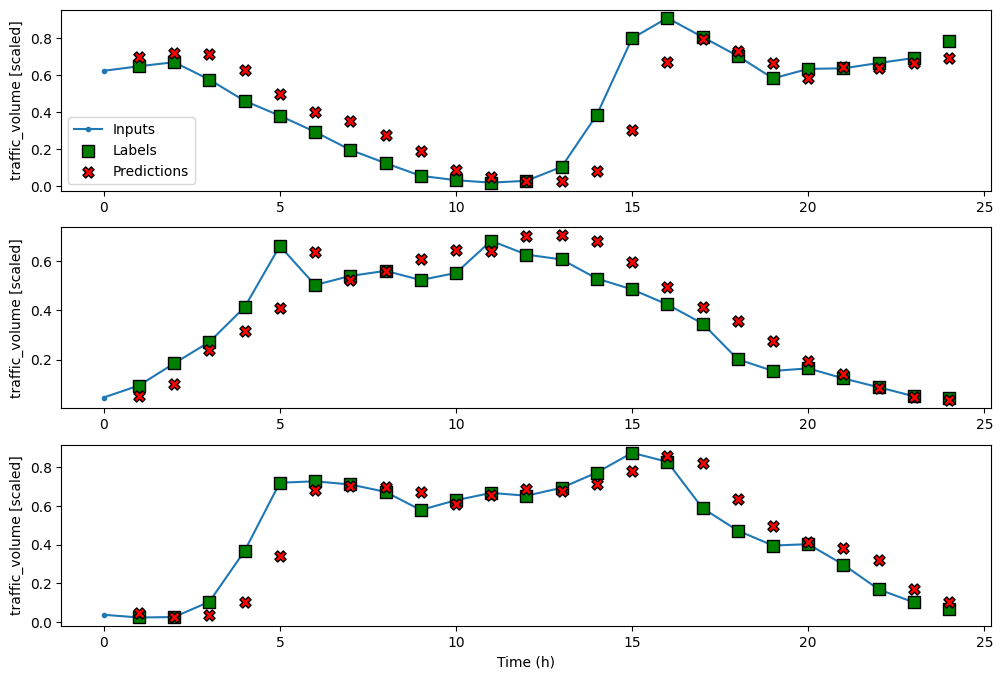

In [36]:
wide_window.plot(ms_dense)

### 결과 비교

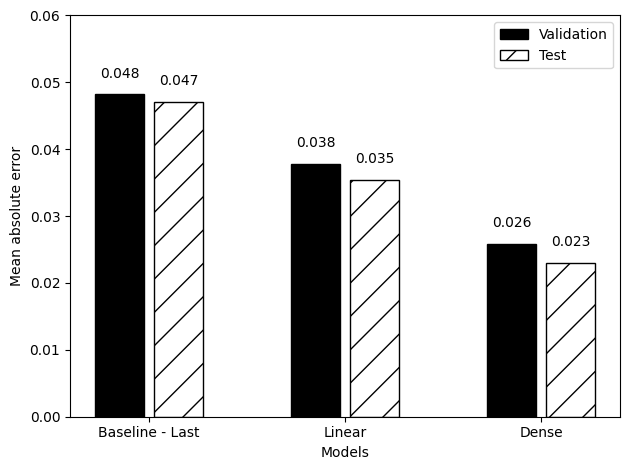

In [37]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()